# Import needed packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
from scipy.stats import norm
from scipy.optimize import minimize
from matplotlib.colors import ListedColormap
from time import time
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier



# Load the dataset and initialize it

In [2]:
data = pd.read_csv('C:/Users/Pc_User/Desktop/ML/Vodafone/data_train.csv') #read the data
y = np.array(data['Footfall']) #get the variable to predict
y_label = np.array(data['Footfall_classif'])

data.drop(['Footfall', 'Footfall_classif'], axis = 1, inplace = True) # drop it from your dataset with the classifier

# Average Min-Max ARPU

Minimum and Maximum value ARPU are very skewed data with little variance, by taking the average we eliminate some outliers and we ridistribute variance and we center them.

In [3]:
AVG_night_scaled_ARPU200 = (data['night_MIN_scaled_ARPU_200'] + data['night_MAX_scaled_ARPU_200']) / 2
AVG_midday_scaled_ARPU200 = (data['midday_MIN_scaled_ARPU_200'] + data['midday_MAX_scaled_ARPU_200']) / 2
AVG_weekend_scaled_ARPU200 = (data['weekend_MIN_scaled_ARPU_200'] + data['weekend_MAX_scaled_ARPU_200']) / 2
AVG_night_scaled_ARPU500 = (data['night_MIN_scaled_ARPU_500'] + data['night_MAX_scaled_ARPU_500']) / 2
AVG_midday_scaled_ARPU500 = (data['midday_MIN_scaled_ARPU_500'] + data['midday_MAX_scaled_ARPU_500']) / 2
AVG_weekend_scaled_ARPU500 = (data['weekend_MIN_scaled_ARPU_500'] + data['weekend_MAX_scaled_ARPU_500']) / 2
AVG_night_scaled_ARPU1000 = (data['night_MIN_scaled_ARPU_1000'] + data['night_MAX_scaled_ARPU_1000']) / 2
AVG_midday_scaled_ARPU1000 = (data['midday_MIN_scaled_ARPU_1000'] + data['midday_MAX_scaled_ARPU_1000']) / 2
AVG_weekend_scaled_ARPU1000 = (data['weekend_MIN_scaled_ARPU_1000'] + data['weekend_MAX_scaled_ARPU_1000']) / 2

AVG = pd.concat([AVG_night_scaled_ARPU200, AVG_midday_scaled_ARPU200, AVG_weekend_scaled_ARPU200, AVG_night_scaled_ARPU500, AVG_midday_scaled_ARPU500, AVG_weekend_scaled_ARPU500, AVG_night_scaled_ARPU1000, AVG_midday_scaled_ARPU1000, AVG_weekend_scaled_ARPU1000], axis = 1)
AVG.columns = ['AVG_night_scaled_ARPU200', 'AVG_midday_scaled_ARPU200', 'AVG_weekend_scaled_ARPU200', 'AVG_night_scaled_ARPU500', 'AVG_midday_scaled_ARPU500', 'AVG_weekend_scaled_ARPU500', 'AVG_night_scaled_ARPU1000', 'AVG_midday_scaled_ARPU1000', 'AVG_weekend_scaled_ARPU1000']

# Create dummies out of the categorical variables

In [4]:
dummy_tipologia = pd.DataFrame(pd.get_dummies(data['Tipologia_encoded'])) #get the dummy
dummy_tipologia.columns = ['type0','type1','type2','type3','type4','type6']  #assign them names
dummy_tipologia.drop(['type0', 'type4', 'type6'], axis = 1, inplace = True)
dummy_area = pd.DataFrame(pd.get_dummies(data['area_encoded']))
dummy_area.columns = ['area1','area2','area3','area4']

# Clean up Località and Provincia

There are more than 200 Località and Province: we take the only the ones where we observe an higher number of stores by applying
a threshold depending on the categorical variable

In [5]:
data_test = pd.read_csv('C:/Users/Pc_User/Desktop/ML/Vodafone/data_test.csv')
lentr = data.shape[0]
data_concat = pd.concat([data, data_test], axis = 0) #match train and test set to have a uniform matching  set of dummy variables 

dummy_loc = pd.DataFrame(pd.get_dummies(data_concat['Localita_encoded']))
dummy_prov = pd.DataFrame(pd.get_dummies(data_concat['Provincia_encoded']))

def clean(dummy, threshold):
    l = []
    dummy = np.array(dummy)
    for i in range(dummy.shape[1]):
        l.append(np.sum(dummy[:,i])) #check how many stores
    l = np.array(l)
    col_to_keep = []
    for j in range(len(l > threshold)):
        if (l > threshold)[j] == True: #take the category with highest number of stores
            col_to_keep.append(j)  
    return col_to_keep

col_to_keep = (clean(dummy_loc, 6))
dummy_loc = pd.DataFrame(np.array(dummy_loc)[:,col_to_keep])
dummy_loc.columns = ['loc1', 'loc2', 'loc3','loc4','loc5']
colkeep = (clean(dummy_prov, 10))
dummy_prov = pd.DataFrame(np.array(dummy_prov)[:,colkeep]) 
dummy_prov.columns = ['prov1','prov2','prov3','prov4']

dummy_localita = dummy_loc[:lentr]
dummy_provincia = dummy_prov[:lentr]

data = data_concat[:lentr] #get back the training set

# Build the dataset

In [6]:
data_2 = pd.concat([data, dummy_tipologia, dummy_area, dummy_localita, dummy_provincia], axis = 1, ignore_index = False) 

df = pd.concat([data_2, AVG], axis = 1, ignore_index = False)

df.drop(['night_MIN_scaled_ARPU_200','night_MAX_scaled_ARPU_200', 'midday_MIN_scaled_ARPU_200', 'midday_MAX_scaled_ARPU_200', 'weekend_MIN_scaled_ARPU_200','weekend_MAX_scaled_ARPU_200',
'night_MIN_scaled_ARPU_500','night_MAX_scaled_ARPU_500', 'midday_MIN_scaled_ARPU_500', 'midday_MAX_scaled_ARPU_500', 'weekend_MIN_scaled_ARPU_500','weekend_MAX_scaled_ARPU_500',
'night_MIN_scaled_ARPU_1000','night_MAX_scaled_ARPU_1000', 'midday_MIN_scaled_ARPU_1000', 'midday_MAX_scaled_ARPU_1000', 'weekend_MIN_scaled_ARPU_1000','weekend_MAX_scaled_ARPU_1000'], axis = 1, inplace = True)

df.drop(['Tipologia_encoded', 'area_encoded', 'Store_ID','Localita_encoded','Provincia_encoded'], axis = 1, inplace = True) 

print(df.shape)

(322, 64)


# Ramsey RESET Linearity Test

A Linearity test that checks whether data could be fitted linearly, by first making a normal regression on predicted footfall
and then regress the same footfall on the predicted values of foofall squared (and to the third power).

In [7]:
model = LinearRegression()
datadf = pd.DataFrame(PCA(n_components=4).fit_transform(data))
model.fit(datadf, y)
y_pred = model.predict(datadf) 

y_squared = pd.DataFrame(y_pred**2)
y_third = pd.DataFrame(y_pred**3)

merged_df = pd.concat([datadf, y_squared, y_third], axis = 1) #add to x y_hat^2


modelu = LinearRegression()
modelu.fit(merged_df, y)
y_merged = modelu.predict(merged_df)

RSS_restr = np.sum((y_pred - y)**2)
RSS_unr = np.sum((y_merged - y)**2)
j = 2
F_test = ((RSS_restr - RSS_unr) / j) / (RSS_unr / (322 - 6 - 1))

Critical_value = 4.667 #at a significance level alpha of 0.01

print(F_test) #Value F test is lower than the critical value, H0 of linearity failed to be rejected

4.036142316552256


# Replace null values in Metratura

In [8]:
metratura_median = np.median(df['Metratura_scaled'].values)
missing_values_metratura = np.where(df['Metratura_scaled'].values == 0)
df['Metratura_scaled'].values[missing_values_metratura] = metratura_median


#  Add data to the dataset

We thought that a factor that can influence how many people steps into the store could be related, more than the metratura itself, to how many employess you have per square meter

In [9]:
FTE_per_sqmeter = df['FTE_scaled'] / df['Metratura_scaled'] 
PTE_per_sqmeter = df['PTE_scaled'] / df['Metratura_scaled']
E_sq = pd.concat([FTE_per_sqmeter, PTE_per_sqmeter], axis = 1)
E_sq.columns = ['FTE_per_sqmeter','PTE_per_sqmeter']
ds = pd.concat([df, E_sq], axis = 1)
df = ds.copy()
data_frame = ds.copy()

# Save some useful variables

In [10]:
n_features = df.shape[1] #get the number of features
n_obs = df.shape[0] #get the number of observations

feature_list = df.columns.values #get a list of all the features (coloumns header)
feature_number = len(df.columns.values)

# Forward selection algorithm implementation

Start from an empty dataframe and regress separately each variable with footfall.
Keep the variable with lowest RSS
Reiterate the process until the end by building from scratch a dataframe

In [11]:
ds = df.copy() #get a copy of the dataframe to not mess things up

data = pd.DataFrame() #create an empty dataframe

j = 0 #initialize an index to iterate the process over j periods
variables_order = [] #list that will give the order of the selected variables
#the ith position is the ith most significant variables

RSS_list = []

while j != feature_number - 2:
    
    RSS = []
    
    for i in ds.columns.values:
        data = pd.concat([data, ds[i]], axis = 1)
    
        model = LinearRegression()
        model.fit(data, y)
        predictions = model.predict(data)
    
        RSS.append(np.sum((predictions - y)**2)/data.shape[0])
      
    
        data.drop([i], axis = 1, inplace = True)
    
    index_to_keep = np.argmin(RSS)
    
    variable_to_keep = ds.columns.values[index_to_keep]

    data = pd.concat([data, ds[variable_to_keep]], axis = 1)
    
    model = LinearRegression()
    model.fit(data, y)
    y_hat = model.predict(data)
    
    ds.drop([variable_to_keep], axis = 1, inplace = True)
    
    RSS_list.append(np.sum((predictions - y)**2)/data.shape[0])
    
    variables_order.append(variable_to_keep)
    
    j += 1

# Plot results

This tell us one important thing: taking more than 40 variables is useless

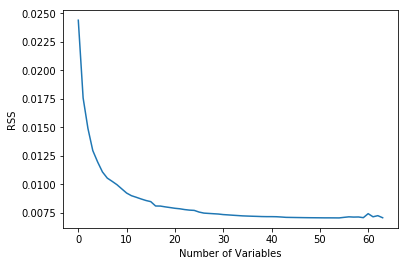

In [12]:
plt.xlabel('Number of Variables')
plt.ylabel('RSS')
plt.plot(np.arange(feature_number - 2), RSS_list)
plt.show()

# How many variables should we use?

In [13]:
scores = []
for i in range(1, 40):
    variables_to_keep = variables_order[:i]
    dataset = pd.concat([df[j] for j in variables_to_keep], axis = 1)
    x_A, x_B, y_A, y_B = train_test_split(dataset, y, random_state = 127)
    model = linear_model.Ridge(1.1)
    model.fit(x_A, y_A)
    predictions = model.predict(x_B)
    scores.append(np.sum((y_B - predictions)**2)/x_B.shape[0])
print(f'optimal number of variables = {np.argmin(scores)}')   
print(f'RSS on test set = {scores[np.argmin(scores)]}')
    


optimal number of variables = 13
RSS on test set = 0.009978641197624


# Decide the number and finalize your dataset

In [14]:
variables_to_keep = variables_order[:13]
dataset = pd.concat([df[j] for j in variables_to_keep], axis = 1)
print(variables_to_keep)
dataset_train = dataset.copy()

['type2', 'CB_Midday_scaled_1000', 'FTE_scaled', 'QAC_Feb_scaled', 'weekend_MEAN_scaled_ARPU_200', 'prov3', 'PTE_scaled', 'prov2', 'loc5', 'CB_Night_scaled_1000', 'CB_Weekend_scaled_1000', 'Metratura_scaled', 'QAC_Oct_scaled']


# Check your error performance on a higher order fitting

In [15]:
RSS_list_val = []
RSS_list_train = []     
RSQ_train = []                                         
RSQ_val = []

X_a, X_b, y_a, y_b = train_test_split(dataset, y, test_size = 0.4, random_state = 50)

for i in range(1,8):
    model = SVR(kernel = 'poly', degree = i, cache_size = 7000)
    model.fit(X_a, y_a)
    predictions_train = model.predict(X_a)
    predictions_val = model.predict(X_b)
    RSS_list_val.append(np.sum((predictions_train - y_a)**2))
    RSS_list_train.append(np.sum((predictions_val - y_b))**2)
    RSQ_train.append(model.score(X_a, y_a))
    RSQ_val.append(model.score(X_b, y_b))

# Plot the results

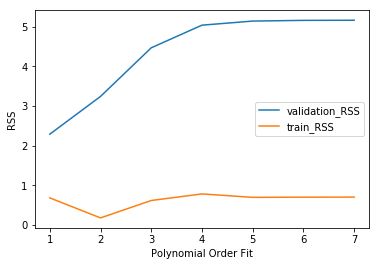

In [16]:
plt.plot(np.arange(1,8), RSS_list_val, label = 'validation_RSS')
plt.plot(np.arange(1,8), RSS_list_train, label = 'train_RSS')
plt.xlabel('Polynomial Order Fit')
plt.ylabel('RSS')
plt.legend()

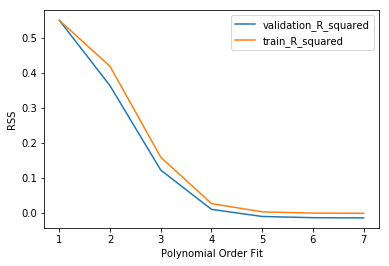

In [17]:
plt.clf()
plt.plot(np.arange(1,8), RSQ_train, label = 'validation_R_squared')
plt.plot(np.arange(1,8), RSQ_val, label = 'train_R_squared')  
plt.xlabel('Polynomial Order Fit')
plt.ylabel('RSS')
plt.legend()

# Split the data in training and test to check your performace

In [18]:
x_A, x_B, y_A, y_B = train_test_split(dataset, y, random_state = 127)

# Optimize Hyperparameters for SVD

We "implement" now a grid search now to optimize hyperparameter of support vector regression by trying every possible combination of these values

In [19]:
C_values = [50, 55, 60, 70,100, 105,110,115,120, 200]
gamma_values = [0.01, 0.03, 0.1, 0.2, 0.11, 0.15, 0.25, 0.3, 0.09, 1, 10, 100]

best_RSS_test = 1000
best_params = {'C': None, 'gamma':None}

for C in C_values:
    for gamma in gamma_values:
        model = SVR(C = C, gamma = gamma, cache_size = 7000)
        model.fit(x_A, y_A)
        predictions = model.predict(x_B)
        RSS_test = np.sum((y_B - predictions)**2) / x_B.shape[0]
        
        
        if RSS_test < best_RSS_test:
            best_RSS_test = RSS_test
            best_params['C'] = C
            best_params['gamma'] = gamma
print(f'best RSS test = {best_RSS_test}')
print(best_params)

best RSS test = 0.009225610276156985
{'C': 60, 'gamma': 0.03}


# Optimize Hyperparameters for Ridge Regression

In [20]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.4, 0.5,0.6, 0.7, 0.8,0.9, 1, 1.1]

best_RSS_test = 1000
best_params = 0
scores = []

for alpha in alphas:
    model = linear_model.Ridge(alpha)
    model.fit(x_A, y_A)
    predictions = model.predict(x_B)
    RSS_test = np.sum((y_B - predictions)**2) / x_B.shape[0]
        
    if RSS_test < best_RSS_test:
        best_RSS_test = RSS_test
        best_params = alpha
print(f'best RSS test = {best_RSS_test}')
print(f'best parameter = {best_params}')

best RSS test = 0.009437574322278344
best parameter = 0.1


# Optimize Hyperparameters with Bayesian Optimization

Bayesian optimization is a very powerful tools that allows us to optimize the hyperparameters of our model with the following steps:
Tell the algorithm your prior beliefs about the parameter values and bounds
Minimize a loss function (in our case the RSS on the validation set)
Sample the next hyperparameter by maximizing the utility given by the expected improvement function

# Define Expected Improvement Function

In [21]:
def expected_improvement(x, gaussian_process, evaluated_loss, maximize=False, n_params=1):
    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if maximize:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not maximize)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement

# Sample the next hyperparameter

In [22]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, maximize=False,
                               bounds=(0, 10), n_restarts=25):
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, maximize, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

# Core of Bayesian Algorithm

In [23]:
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    x_l= []
    y_l= []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_l.append(params)
            y_l.append(sample_loss(params))
    else:
        for params in x0:
            x_l.append(params)
            y_l.append(sample_loss(params))

    xp = np.array(x_l)
    yp = np.array(y_l)

    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, maximize=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, maximize=True, bounds=bounds, n_restarts=100)

        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        cv_score = sample_loss(next_sample)

        x_l.append(next_sample)
        y_l.append(cv_score)

        # Update xp and yp
        xp = np.array(x_l)
        yp = np.array(y_l)

    return xp, yp

# Make your prior guesses about your parameters

In [24]:
params = [60,0.03]
bounds = np.array([[55, 65], [0.028, 0.032]])

# Your loss function to optimize is your RSS on the validation set

In [25]:
def sample_loss(params):
    model = SVR(C = params[0], gamma = params[1], cache_size = 7000)
    model.fit(x_A, y_A)
    predictions = model.predict(x_B)
    return np.sum((y_B - predictions)**2) / x_B.shape[0]

# Get the results

In [26]:
params_couples, RSS_min = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)
print(np.argmin(RSS_min))
print(RSS_min[np.argmin(RSS_min)])
best_parameters = params_couples[np.argmin(RSS_min)]
print(best_parameters)

12
0.00920355872933157
[5.50045126e+01 3.17869127e-02]


# Rearrange the test dataset to make it compatible to the training set

In [27]:
data = pd.read_csv('C:/Users/Pc_User/Desktop/ML/Vodafone/data_test.csv') 

AVG_night_scaled_ARPU200 = (data['night_MIN_scaled_ARPU_200'] + data['night_MAX_scaled_ARPU_200']) / 2
AVG_midday_scaled_ARPU200 = (data['midday_MIN_scaled_ARPU_200'] + data['midday_MAX_scaled_ARPU_200']) / 2
AVG_weekend_scaled_ARPU200 = (data['weekend_MIN_scaled_ARPU_200'] + data['weekend_MAX_scaled_ARPU_200']) / 2
AVG_night_scaled_ARPU500 = (data['night_MIN_scaled_ARPU_500'] + data['night_MAX_scaled_ARPU_500']) / 2
AVG_midday_scaled_ARPU500 = (data['midday_MIN_scaled_ARPU_500'] + data['midday_MAX_scaled_ARPU_500']) / 2
AVG_weekend_scaled_ARPU500 = (data['weekend_MIN_scaled_ARPU_500'] + data['weekend_MAX_scaled_ARPU_500']) / 2
AVG_night_scaled_ARPU1000 = (data['night_MIN_scaled_ARPU_1000'] + data['night_MAX_scaled_ARPU_1000']) / 2
AVG_midday_scaled_ARPU1000 = (data['midday_MIN_scaled_ARPU_1000'] + data['midday_MAX_scaled_ARPU_1000']) / 2
AVG_weekend_scaled_ARPU1000 = (data['weekend_MIN_scaled_ARPU_1000'] + data['weekend_MAX_scaled_ARPU_1000']) / 2

AVG = pd.concat([AVG_night_scaled_ARPU200, AVG_midday_scaled_ARPU200, AVG_weekend_scaled_ARPU200, AVG_night_scaled_ARPU500, AVG_midday_scaled_ARPU500, AVG_weekend_scaled_ARPU500, AVG_night_scaled_ARPU1000, AVG_midday_scaled_ARPU1000, AVG_weekend_scaled_ARPU1000], axis = 1)
AVG.columns = ['AVG_night_scaled_ARPU200', 'AVG_midday_scaled_ARPU200', 'AVG_weekend_scaled_ARPU200', 'AVG_night_scaled_ARPU500', 'AVG_midday_scaled_ARPU500', 'AVG_weekend_scaled_ARPU500', 'AVG_night_scaled_ARPU1000', 'AVG_midday_scaled_ARPU1000', 'AVG_weekend_scaled_ARPU1000']

dummy_tipologia = pd.DataFrame(pd.get_dummies(data['Tipologia_encoded'])) #get the dummy
dummy_tipologia.columns = ['type1','type2','type3','type4','type5']  #assign them names
dummy_tipologia.drop(['type4', 'type5'], axis = 1, inplace = True)
dummy_area = pd.DataFrame(pd.get_dummies(data['area_encoded']))
dummy_area.columns = ['area1','area2','area3','area4']


In [29]:
dummy_localita = dummy_loc[lentr:]
dummy_l = np.array(dummy_localita)
dummy_localita = pd.DataFrame(dummy_l)
dummy_localita.columns = ['loc1','loc2','loc3','loc4','loc5']
dummy_provincia = dummy_prov[lentr:]
dummy_p = np.array(dummy_provincia)
dummy_provincia = pd.DataFrame(dummy_p)
dummy_provincia.columns = ['prov1','prov2','prov3','prov4']

dataSet = pd.concat([data, dummy_tipologia, dummy_area, dummy_localita, dummy_provincia, AVG], axis = 1)
variables_selected = ['type2', 'CB_Midday_scaled_1000', 'FTE_scaled', 'QAC_Feb_scaled', 'weekend_MEAN_scaled_ARPU_200', 'prov3', 'PTE_scaled', 'prov2', 'loc5', 'CB_Night_scaled_1000', 'CB_Weekend_scaled_1000', 'Metratura_scaled', 'QAC_Oct_scaled']
dataset_final = pd.concat([dataSet[i] for i in variables_selected], axis = 1)

C = best_parameters[0]
gamma = best_parameters[1]
model = SVR(C = C, gamma = gamma, cache_size = 7000)
model.fit(dataset_train, y)
predictions = model.predict(dataset_final)

print(predictions)


[0.16278366 0.2838775  0.27515856 0.20417606 0.18066477 0.28249093
 0.06114364 0.22960833 0.3861308  0.33492225 0.2601166  0.36979054
 0.33907147 0.26192272 0.08743594 0.20723181 0.19003581 0.25468528
 0.14506024 0.39426719 0.18125036 0.20138305 0.14255127 0.34801639
 0.3716144  0.28646171 0.39075432 0.37862998 0.41148598 0.3219884
 0.27025466 0.35076873 0.12441914 0.37997496 0.24390624 0.27098663
 0.46138814 0.26841559 0.21017715 0.23836983 0.50747851 0.50374212
 0.25787454 0.24124564 0.4734673  0.38404303 0.31295394 0.42220601
 0.1826928  0.29459086 0.16637771 0.40678118 0.35617756 0.14191267
 0.30818211 0.4841834  0.4434937  0.08811835 0.27925723 0.54649907
 0.32672484 0.18175967 0.40647126 0.07002323 0.46013847 0.15564486
 0.16400772 0.35761846 0.19840658 0.16572417 0.33832414 0.44637148
 0.15379291 0.46492751 0.14759357 0.23300826 0.08580702 0.22452906
 0.25004005 0.17141446 0.24422622]


# Rearrange the dataframe for classification

In [30]:
data=pd.read_csv('C:/Users/Pc_User/Desktop/ML/Vodafone/data_train.csv')


data['Metratura_scaled'] = data['Metratura_scaled'].replace(0, np.NaN)
data.fillna(data['Metratura_scaled'].mean(), inplace=True)

y2=data['Footfall_classif']
y=data['Footfall']
data.drop(['Store_ID','Footfall','Provincia_encoded', 'Localita_encoded', 'Footfall_classif'], axis = 1, inplace = True)

data.drop(['midday_MIN_scaled_ARPU_1000','midday_MIN_scaled_ARPU_200', 'midday_MIN_scaled_ARPU_500','night_MIN_scaled_ARPU_1000','night_MIN_scaled_ARPU_200', 'night_MIN_scaled_ARPU_500'], axis = 1, inplace = True)

df = data.copy()

n_features = df.shape[1] #get the number of features
n_obs = df.shape[0] #get the number of observations

feature_list = df.columns.values #get a list of all the features (coloumns header)
feature_number = len(df.columns.values)

C:\Users\Pc_User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


<Figure size 432x288 with 0 Axes>

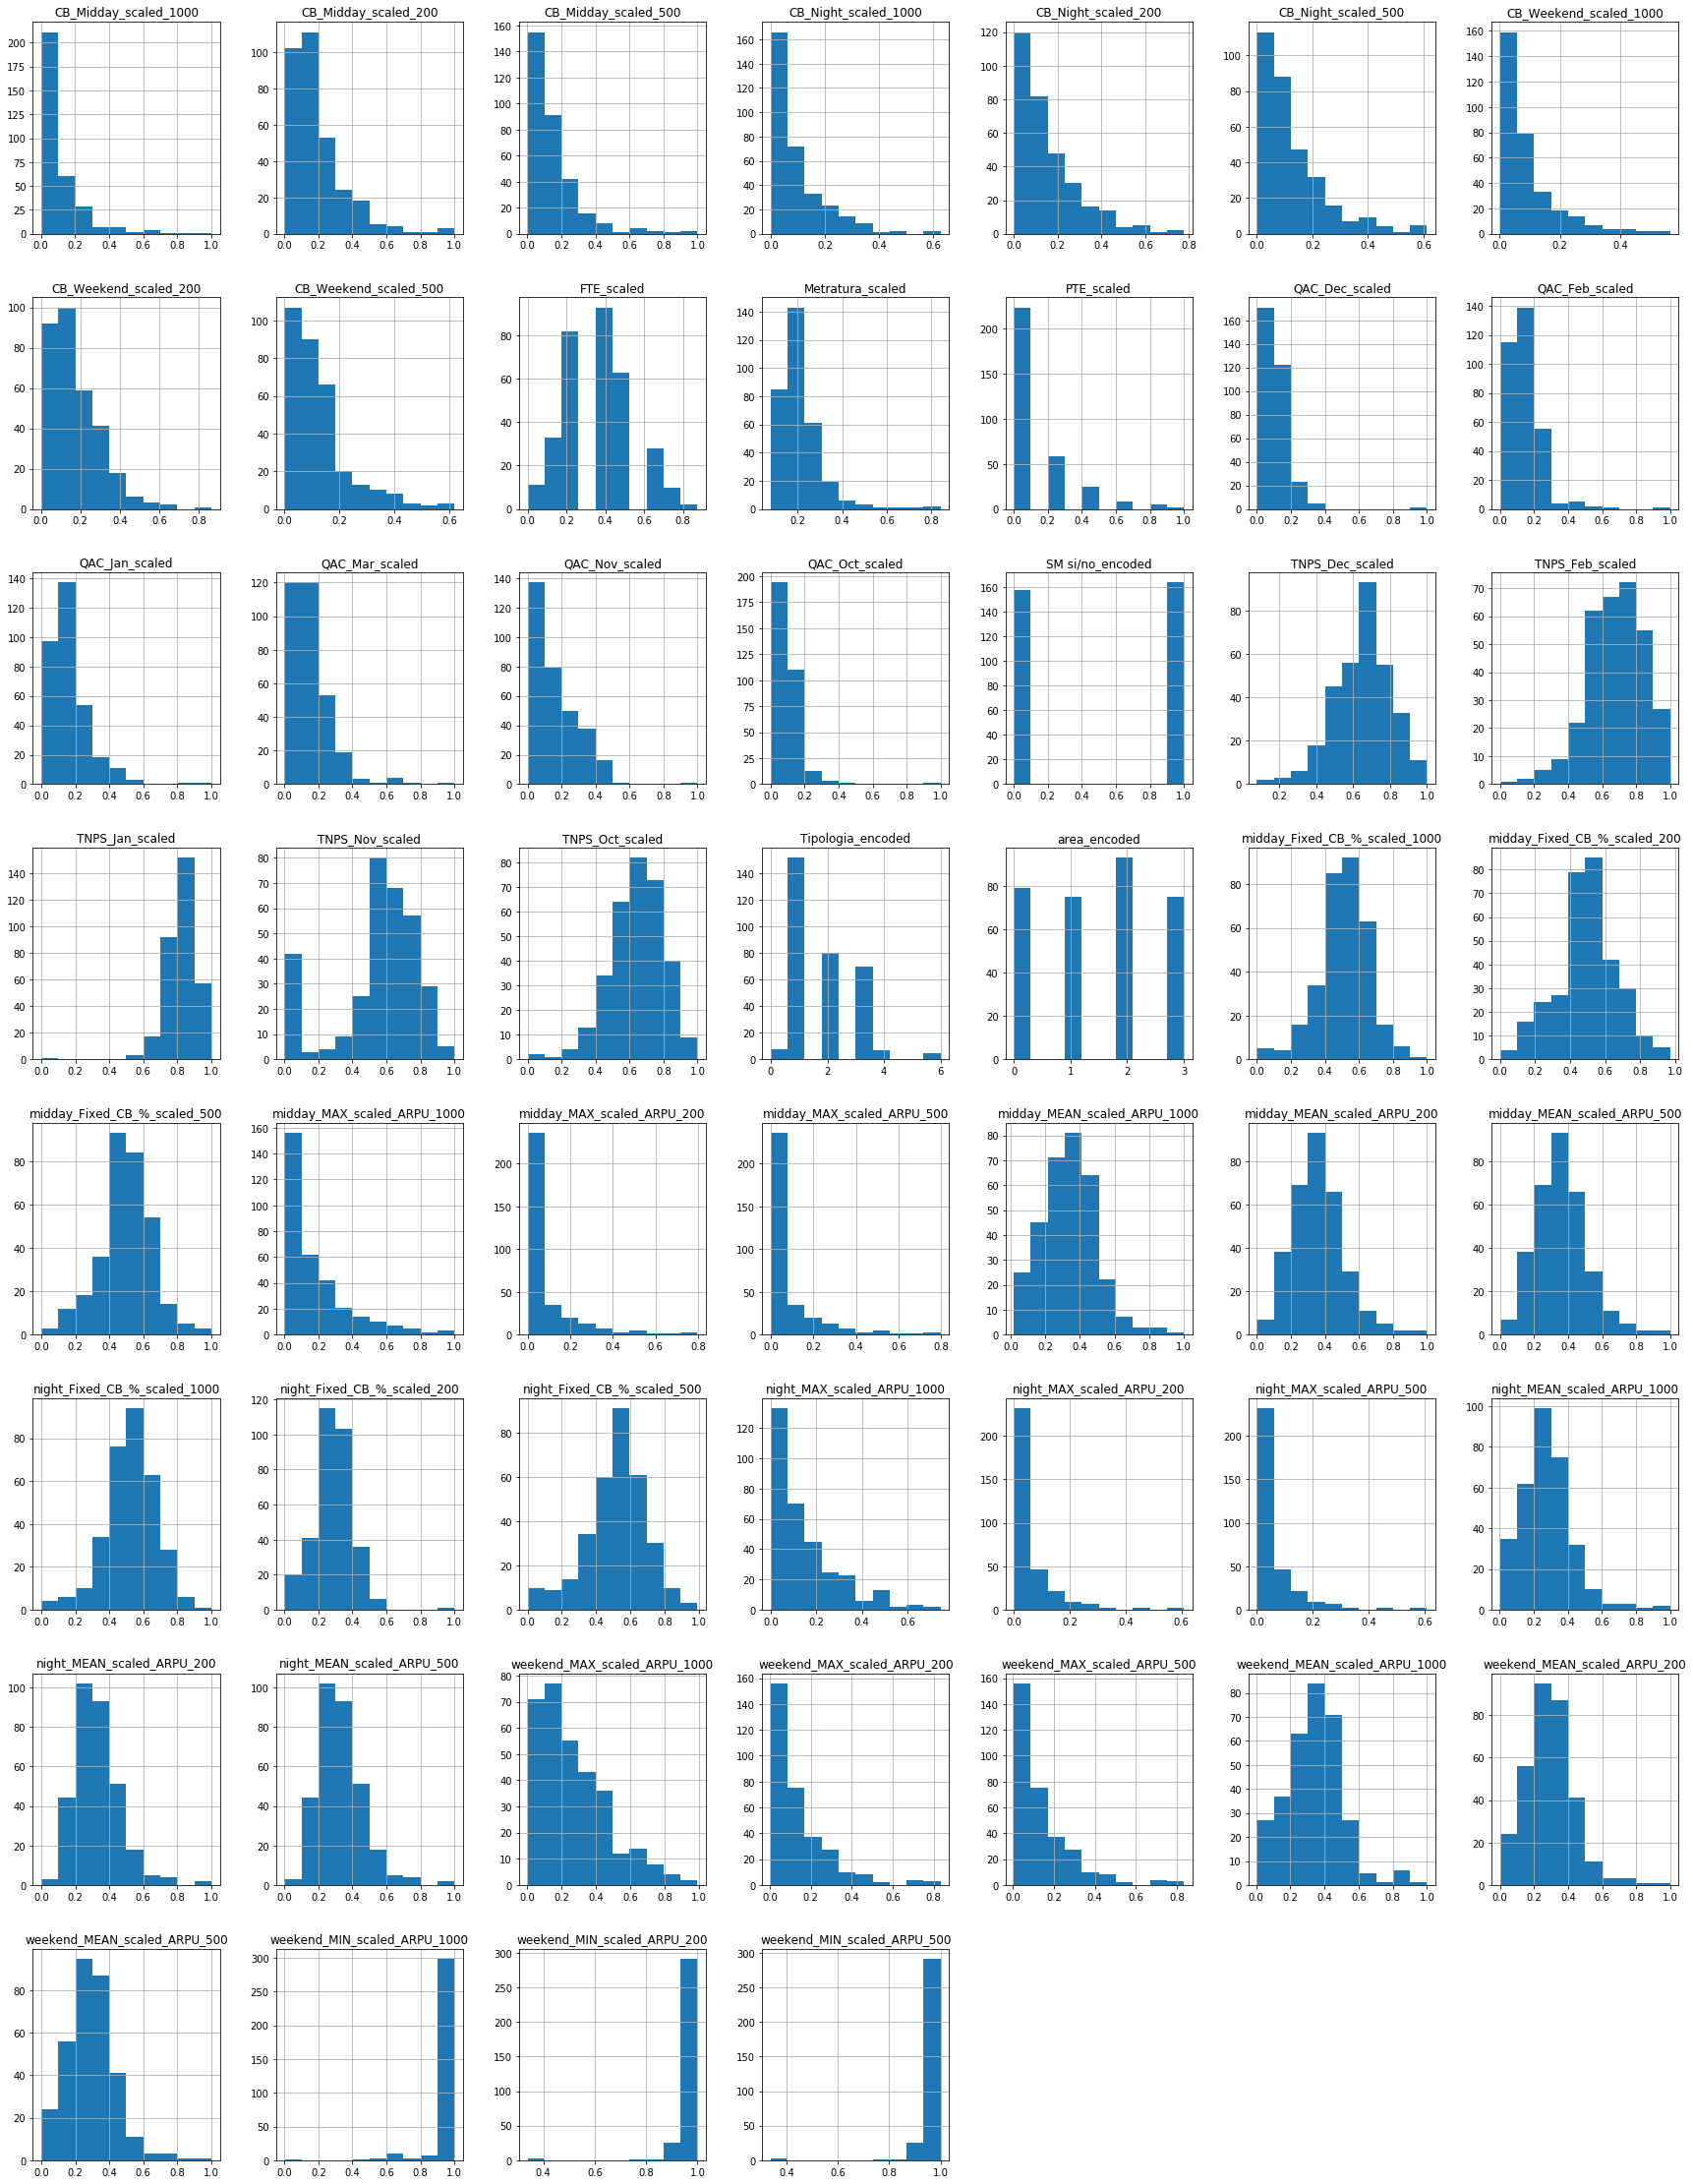

In [31]:
plt.clf()
fig = plt.figure(figsize = (30,40))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

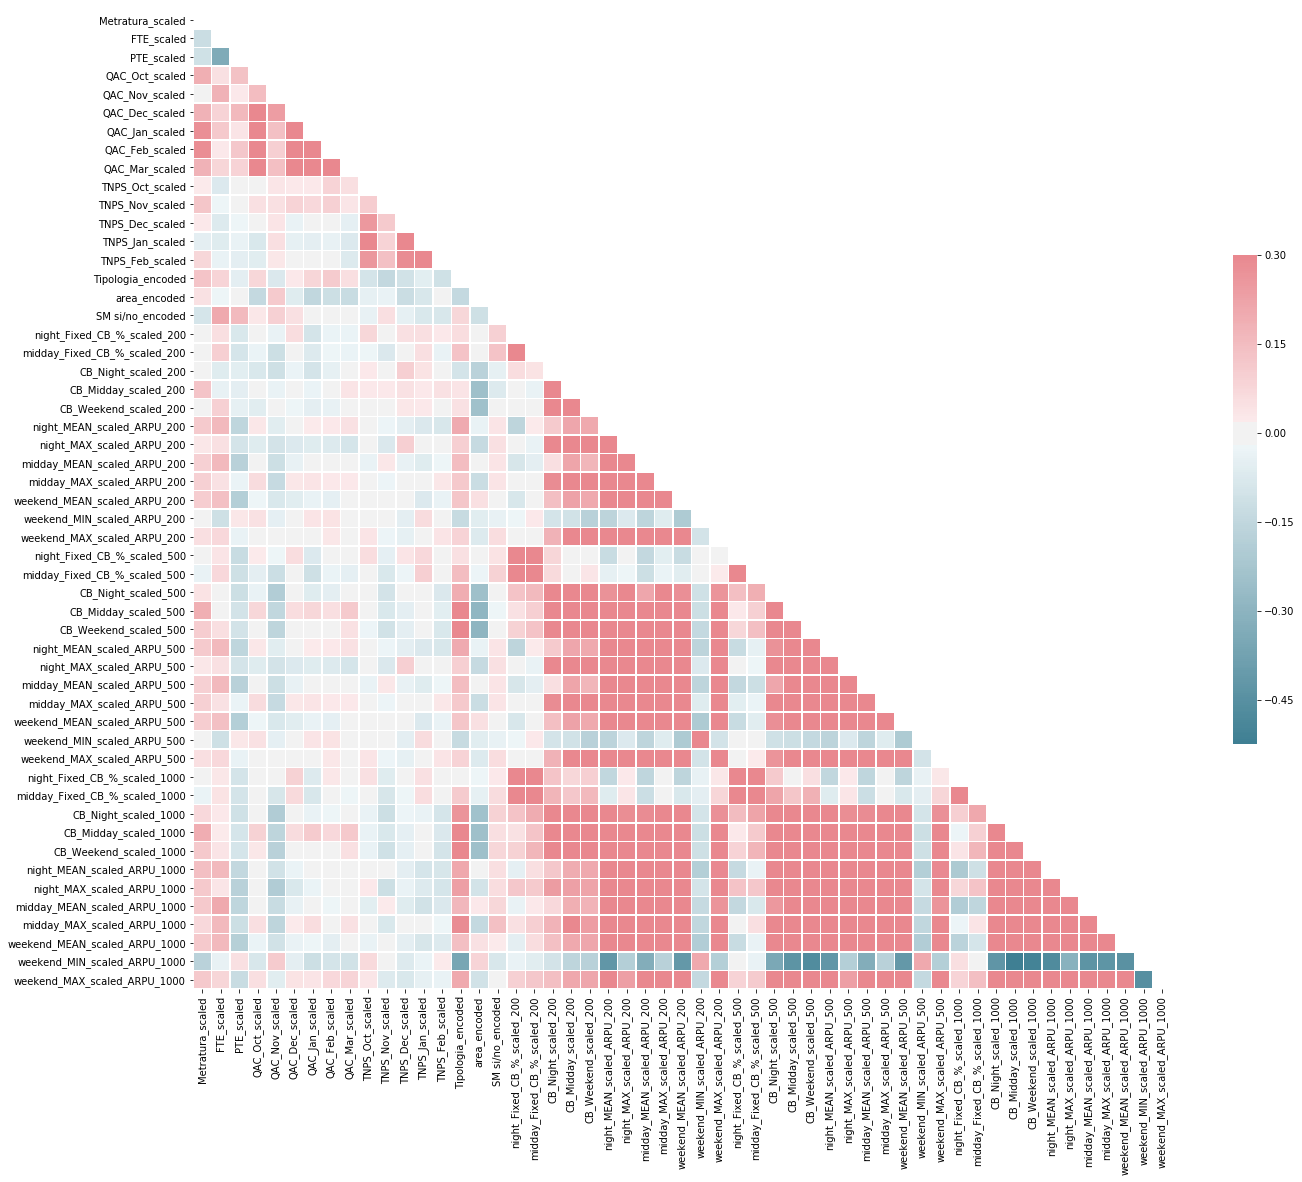

In [32]:
import seaborn as sns
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# PCA

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df, y2, test_size=0.20, random_state = 12323)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_  
print(np.cumsum(explained_variance))

[0.26622106 0.37207827 0.45107071 0.52065996 0.56625261 0.60452635
 0.64268693 0.67594443 0.70356645 0.73046504 0.75659933 0.77909248
 0.79873492 0.81706185 0.8340344  0.84873017 0.86245682 0.87603836
 0.88844229 0.8997069  0.91048442 0.92010144 0.92923621 0.9372603
 0.94503135 0.95152497 0.95713729 0.96263977 0.96758591 0.97207627
 0.9758564  0.97948334 0.98274929 0.98563436 0.98845398 0.990909
 0.99332982 0.99505721 0.99670471 0.99764509 0.99840995 0.99896844
 0.99935706 0.9996814  0.99990214 1.         1.         1.
 1.         1.         1.         1.         1.        ]


# We need around 30 PCs to explain enough accumulated variance

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df, y2, test_size=0.20, random_state = 12323)  

pca = PCA(n_components = 29)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Grid Search for SVC

In [35]:
C_values = [1, 5, 6, 9.89, 9.91, 9.9,10,10.1, 12, 20,20.96,21, 21.01,30,40,  49, 50, 51, 100, 200, 300, 400, 490, 500, 510, 600, 700, 800, 1000]
gamma_values = [0.0001, 0.01, 0.02,0.04,  0.099, 0.1,0.101, 0.2,0.21,0.19, 0.3]

best_score_test = 0
best_params = {'C': None, 'gamma':None}

for C in C_values:
    for gamma in gamma_values:
        classifier = SVC(kernel = 'rbf', C = C, gamma = gamma, cache_size = 7000)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        score_test = accuracy_score(y_test, y_pred)

        if score_test > best_score_test:
            best_score_test = score_test
            best_params['C'] = C
            best_params['gamma'] = gamma
print(f'best test score = {best_score_test}')
print(best_params)

best test score = 0.7076923076923077
{'C': 20.96, 'gamma': 0.1}


# Build a classifier set


In [36]:
names = ['l2regression','LinearSVC','NonLinearSVC', 'KNeighbors','GPC','DecisionTree','Random_forest']
classifierSet = [LogisticRegression(penalty='l2',solver='saga', multi_class = 'ovr', max_iter = 1000),
                 SVC(kernel='linear'),
                 SVC(kernel = 'rbf', gamma = best_params['gamma'], C = best_params['C']),
                 KNeighborsClassifier(3),
                 GaussianProcessClassifier(),
                 DecisionTreeClassifier(),
                 RandomForestClassifier(n_estimators=2000, random_state=0)]

print("Name             Accuracy")
i = 0

for classifier in classifierSet:
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("%s   %0.1f%%" % (names[i].ljust(16), accuracy * 100))
    i += 1

Name             Accuracy
l2regression       52.3%
LinearSVC          52.3%
NonLinearSVC       70.8%
KNeighbors         46.2%
GPC                52.3%
DecisionTree       35.4%
Random_forest      49.2%


# Start classification with non-linear SVC

In [37]:
model = SVC(gamma = best_params['gamma'], C = best_params['C'])
model.fit(X_train, y_train) #X_train/test ecc are taken from the initial df(database train) with the split method
predicted_classes = model.predict(X_test)

#calculate accuracy
accuracy = accuracy_score(y_test,predicted_classes)
print('accuracy svc= ',accuracy)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predicted_classes))  
print(classification_report(y_test,predicted_classes)) 

accuracy svc=  0.7076923076923077
[[11  6  0]
 [ 7 14  5]
 [ 0  1 21]]
             precision    recall  f1-score   support

          0       0.61      0.65      0.63        17
          1       0.67      0.54      0.60        26
          2       0.81      0.95      0.88        22

avg / total       0.70      0.71      0.70        65



# Set up the test database

In [38]:
#set for the test
test = pd.read_csv('C:/Users/Pc_User/Desktop/ML/Vodafone/data_test.csv') #read the data

test.drop(['Store_ID','Provincia_encoded', 'Localita_encoded'], axis = 1, inplace = True) #drop it from your dataset

test['Metratura_scaled'] = test['Metratura_scaled'].replace(0, np.NaN)
test.fillna(data['Metratura_scaled'].mean(), inplace=True)

test.drop(['midday_MIN_scaled_ARPU_1000','midday_MIN_scaled_ARPU_200', 'midday_MIN_scaled_ARPU_500','night_MIN_scaled_ARPU_1000','night_MIN_scaled_ARPU_200', 'night_MIN_scaled_ARPU_500'], axis = 1, inplace = True)

datset_test = pca.transform(test)
datset_test = pd.DataFrame(datset_test)



C:\Users\Pc_User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


<Figure size 432x288 with 0 Axes>

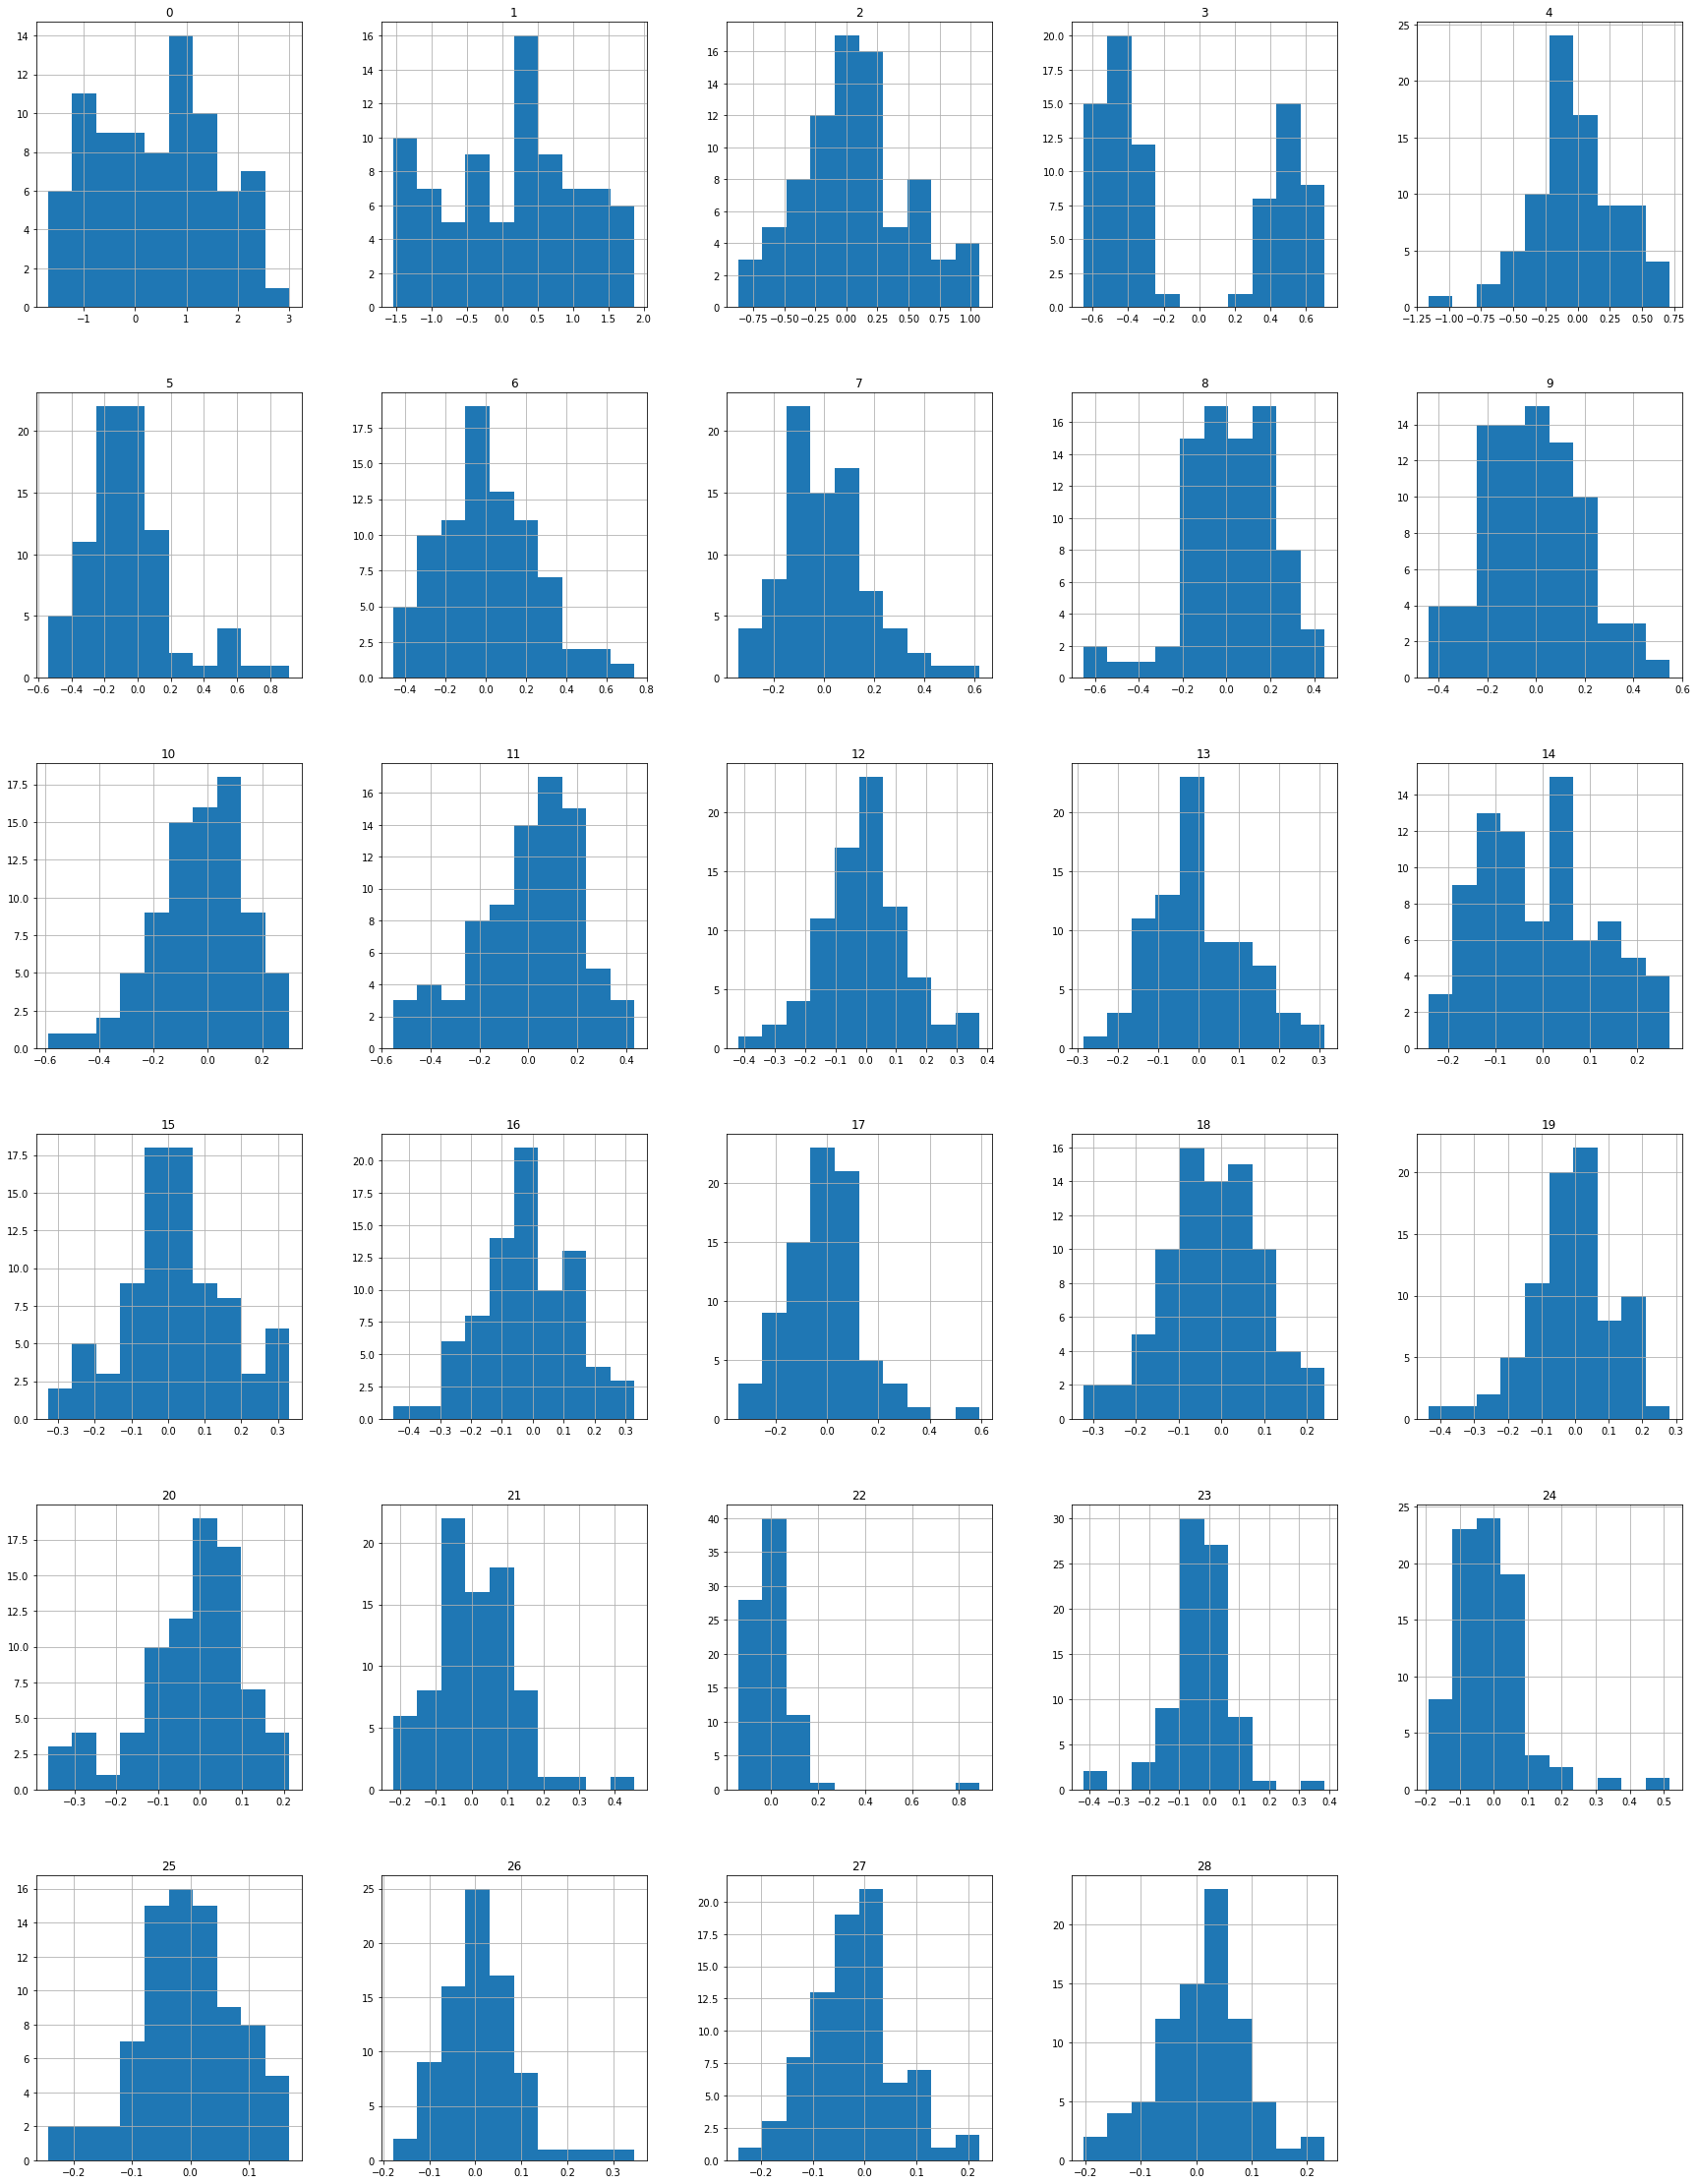

In [39]:
plt.clf()
fig = plt.figure(figsize = (30,40))
ax = fig.gca()
datset_test.hist(ax = ax)
plt.show()

# Final predictions for the labels

In [40]:
#Final prediction labels SVC
model = SVC(gamma = best_params['gamma'], C = best_params['C'])
model.fit(X_train, y_train)#df is the initial databse used for train. y2 is the Footfall_classif col
final_prediction_labels = model.predict(datset_test)#dtest is the test database as a whole
print(final_prediction_labels)

[1 1 1 0 0 2 0 0 1 1 1 0 0 1 0 0 0 1 0 2 1 0 1 2 0 1 2 2 1 1 0 2 0 2 1 1 1
 0 1 1 2 2 1 0 2 2 1 2 0 1 1 1 1 0 1 2 1 0 2 2 2 0 2 0 2 0 0 2 2 0 2 2 0 2
 1 1 0 0 1 0 0]
